In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import pandas

In [2]:
%matplotlib inline

In [3]:
class read_data():

  def __init__(self, csv_file):

    self.dt = pandas.read_csv(csv_file)
    pass

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):

    img_values = torch.cuda.FloatTensor(self.dt.iloc[index, 1:].values)/255.0
    return img_values

  def draw_img(self, index):
     img_values = (self.dt.iloc[index, 1:].values.reshape(28,28))
     plt.imshow(img_values, cmap='Blues')
     pass


In [5]:
train_dataset = read_data('dataset/train_60000.csv')

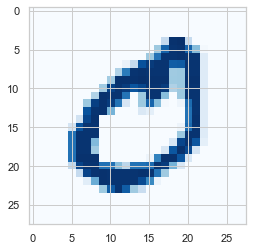

In [6]:
train_dataset.draw_img(20)

In [7]:
class discriminator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784, 300),
        nn.LeakyReLU(0.3),
        nn.LayerNorm(300),

        nn.Linear(300, 1),
        nn.Sigmoid()
    ).cuda()

    self.loss_function = nn.BCELoss()
    self.optimizer = optim.Adam(self.parameters(), lr=0.00005)

    self.counter =0
    self.progress = []

    pass
  def forward(self, inputs):

    return self.model(inputs)

  def train(self, inputs, targets):

    output = self.forward(inputs)
    loss = self.loss_function(output, targets)

    self.counter+=1
    if self.counter%10 ==0:
      self.progress.append(loss.item())

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass

In [11]:
%%timeit
class generator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(200, 300),
        nn.LeakyReLU(0.3),
        nn.LayerNorm(300),

        nn.Linear(300, 784),
        nn.Sigmoid()
    ).cuda()

    self.optimizer = optim.Adam(self.parameters(), lr=0.00005)

    self.counter =0
    self.progress = []

    pass

  def forward(self, inputs):

    return self.model(inputs)

  def train(self, D, inputs, targets):
    gen = self.forward(inputs)
    outputs = D.forward(gen)
    loss = D.loss_function(outputs, targets)

    self.counter+=1
    if self.counter%10 ==0:
      self.progress.append(loss.item())

    self.optimizer.zero_grad()
    loss.backward()
    self.optimizer.step()

    pass

4.12 µs ± 87.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [12]:
%%timeit
D = discriminator()
G = generator()

for i in range(4):
  for img in train_dataset:
    D.train(img, torch.cuda.FloatTensor([1.0]))

    D.train(G.forward(torch.randn(200).cuda()).detach(), torch.cuda.FloatTensor([0.0]))

    G.train(D, torch.randn(200).cuda(), torch.cuda.FloatTensor([1.0]))

21min 58s ± 38.7 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


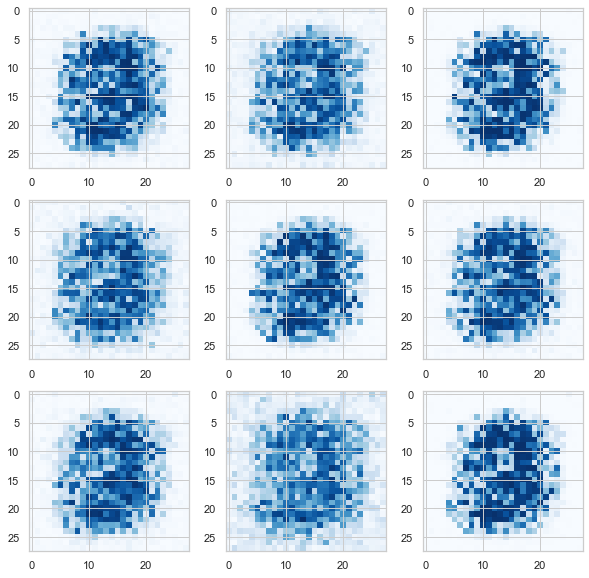

In [18]:
f, array = plt.subplots(3,3,figsize=(10,10))
for i in range(3):
    for j in range(3):
        array[i,j].imshow(G.forward(torch.randn(200).cuda()).cpu().detach().numpy().reshape(28,28), cmap='Blues')

<AxesSubplot:>

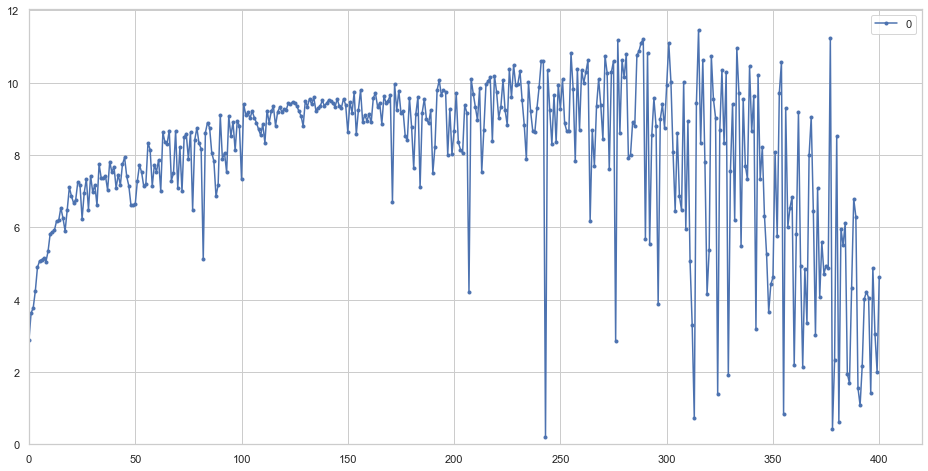

In [19]:
pandas.DataFrame(G.progress).plot(figsize=(16,8), ylim=(0), xlim=0, marker='.')

<AxesSubplot:>

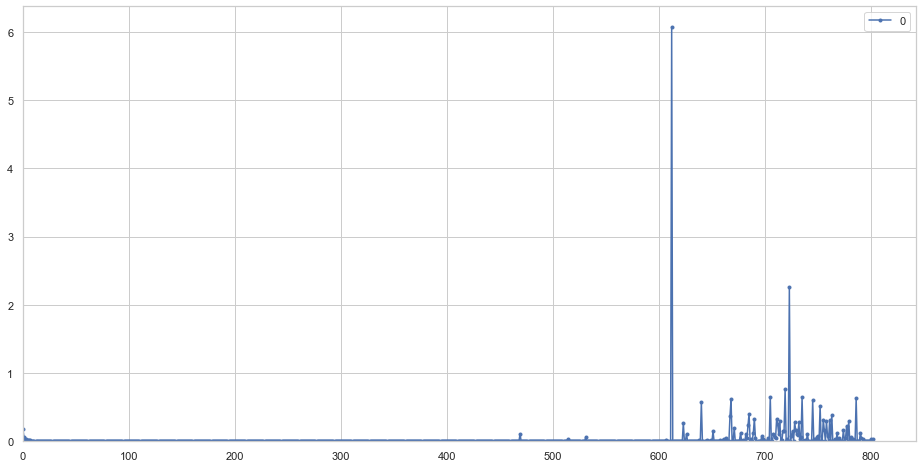

In [20]:
pandas.DataFrame(D.progress).plot(figsize=(16,8), ylim=(0), xlim=0, marker='.')